### Dataset

In [1]:
import pandas as pd
from datasets import Dataset

df1 = pd.read_json('detection_dataset_1st_iter.jsonl', lines=True)
df2 = pd.read_json('detection_dataset_2nd_iter.jsonl', lines=True)
df3 = pd.read_json('detection_dataset_3rd_iter_2e-5.jsonl', lines=True)
df4 = pd.read_json('detection_dataset_3rd_iter_2e-4.jsonl', lines=True)
df5 = pd.read_json('detection_dataset_3rd_iter_2e-4_v2.jsonl', lines=True)

combined_df = pd.concat([df1, df2, df3, df4, df5], ignore_index=True).drop_duplicates()
dataset = Dataset.from_pandas(combined_df)

# for final evaluation
dataset_survey = Dataset.from_pandas(pd.read_json('survey/samples_for_survey.jsonl', lines=True))

In [2]:
import numpy as np
import evaluate
from sklearn.metrics import fbeta_score

accuracy_metric = evaluate.load("accuracy")
precision_metric = evaluate.load("precision")
recall_metric = evaluate.load("recall")
f1_metric = evaluate.load("f1")
roc_auc_metric = evaluate.load("roc_auc")

def compute_metrics(eval_pred):
    predictions, labels = eval_pred

    prediction_scores = predictions[:, 1]
    predicted_labels = np.argmax(predictions, axis=1)

    return {
        "accuracy": accuracy_metric.compute(predictions=predicted_labels, references=labels)["accuracy"],
        "precision": precision_metric.compute(predictions=predicted_labels, references=labels, average='weighted')["precision"],
        "recall": recall_metric.compute(predictions=predicted_labels, references=labels, average='weighted')["recall"],
        "f1": f1_metric.compute(predictions=predicted_labels, references=labels, average='weighted')["f1"],
        "f2": fbeta_score(labels, predicted_labels, beta=2, average="weighted"),
        "roc_auc": roc_auc_metric.compute(prediction_scores=prediction_scores, references=labels)["roc_auc"]
    }

In [17]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

tokenizer = AutoTokenizer.from_pretrained("prajjwal1/bert-tiny")

id2label = {0: "REAL", 1: "GENERATED"}
label2id = {"REAL": 0, "GENERATED": 1}

model = AutoModelForSequenceClassification.from_pretrained(
    "prajjwal1/bert-tiny", num_labels=2, id2label=id2label, label2id=label2id
)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at prajjwal1/bert-tiny and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [18]:
def preprocess_function(examples):
    return tokenizer(examples["text"], truncation=True, padding='max_length', max_length=60)

#### Final run

In [19]:
from datasets import ClassLabel
from collections import Counter

label_feature = ClassLabel(names=["0", "1"])

# look at the first 120 characters of the text as esacpe quotes were removed for the survey ==> the final distribution is not exactly 50:50, but we don't want the data leakage!
signs_number = 120
survey_set = set(t.strip().lower()[:signs_number] for t in dataset_survey["text"])
tokenized_data_survey = dataset.filter(lambda example: example["text"].strip().lower()[:signs_number] in survey_set).map(preprocess_function, batched=True).cast_column("label", label_feature).shuffle(seed=42)

tokenized_data = dataset.filter(lambda example: example["text"].strip().lower()[:signs_number] not in survey_set).map(preprocess_function, batched=True).cast_column("label", label_feature)

tokenized_data = tokenized_data.train_test_split(test_size=0.2, seed=42, stratify_by_column="label")
training_eval_tokenized_data = tokenized_data['train'].train_test_split(test_size=0.1, seed=42, stratify_by_column="label")

print("Train:", Counter(training_eval_tokenized_data["train"]["label"]))
print("Validation:", Counter(training_eval_tokenized_data["test"]["label"]))
print("Test:", Counter(tokenized_data["test"]["label"]))
print("Survey Data:", Counter(tokenized_data_survey["label"]))

Filter:   0%|          | 0/10086 [00:00<?, ? examples/s]

Map:   0%|          | 0/104 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/104 [00:00<?, ? examples/s]

Filter:   0%|          | 0/10086 [00:00<?, ? examples/s]

Map:   0%|          | 0/9982 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/9982 [00:00<?, ? examples/s]

Train: Counter({1: 3931, 0: 3255})
Validation: Counter({1: 437, 0: 362})
Test: Counter({1: 1092, 0: 905})
Survey Data: Counter({0: 53, 1: 51})


### Training

In [20]:
from transformers import TrainingArguments, Trainer, EarlyStoppingCallback, DataCollatorWithPadding

trainer = Trainer(
    model=model,
    train_dataset=training_eval_tokenized_data['train'],
    eval_dataset=training_eval_tokenized_data['test'],
    processing_class=tokenizer,
    data_collator=DataCollatorWithPadding(tokenizer=tokenizer),
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=5)],
    args=TrainingArguments(
        output_dir="results_bert-tiny",
        learning_rate=2e-5,
        per_device_train_batch_size=32,
        per_device_eval_batch_size=16,
        num_train_epochs=15,
        weight_decay=0.01,
        logging_steps=100,
        eval_steps=100,
        eval_strategy="steps",
        load_best_model_at_end=True,
        metric_for_best_model="f1",
        greater_is_better=True,
        lr_scheduler_type="cosine",
        report_to="none"
    ),
)

trainer.train()

finetuned_model = "bert-tiny-finetuned"
model.save_pretrained(finetuned_model)
tokenizer.save_pretrained(finetuned_model)

Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,F2,Roc Auc
100,0.670200,0.633065,0.670839,0.750013,0.670839,0.625853,0.640031,0.828811
200,0.573800,0.476417,0.863579,0.865879,0.863579,0.862610,0.862694,0.927798
300,0.425000,0.342396,0.902378,0.904005,0.902378,0.901888,0.901874,0.963355
400,0.322800,0.259842,0.931164,0.931238,0.931164,0.931082,0.931102,0.976908
500,0.250800,0.217326,0.939925,0.940273,0.939925,0.939806,0.939808,0.981497
600,0.216100,0.191141,0.941176,0.941362,0.941176,0.941088,0.941098,0.984304
700,0.196800,0.177638,0.943680,0.943873,0.943680,0.943595,0.943603,0.986561
800,0.178900,0.172907,0.949937,0.950481,0.949937,0.949822,0.949799,0.987585
900,0.155800,0.143991,0.956195,0.956209,0.956195,0.956200,0.956197,0.990360
1000,0.153500,0.135328,0.958698,0.958691,0.958698,0.958693,0.958696,0.990689


('bert-tiny-finetuned\\tokenizer_config.json',
 'bert-tiny-finetuned\\special_tokens_map.json',
 'bert-tiny-finetuned\\vocab.txt',
 'bert-tiny-finetuned\\added_tokens.json',
 'bert-tiny-finetuned\\tokenizer.json')

### Evaluation

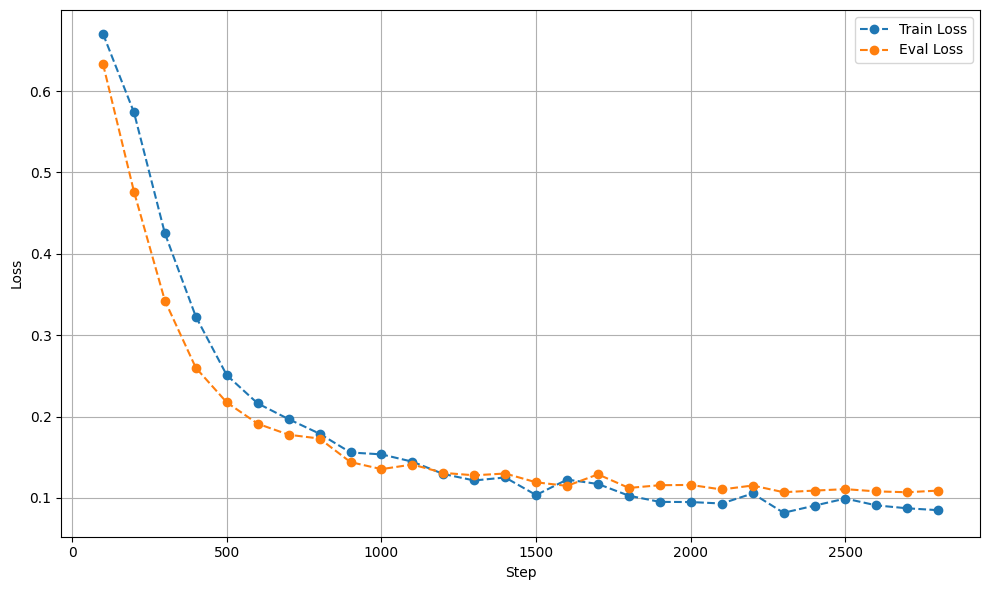

In [21]:
import matplotlib.pyplot as plt

logs = trainer.state.log_history

train_steps = [log["step"] for log in logs if "loss" in log and "eval_loss" not in log]
train_losses = [log["loss"] for log in logs if "loss" in log and "eval_loss" not in log]

eval_steps = [log["step"] for log in logs if "eval_loss" in log]
eval_losses = [log["eval_loss"] for log in logs if "eval_loss" in log]

plt.figure(figsize=(10,6))
plt.plot(train_steps, train_losses, label="Train Loss", marker='o', linestyle='--')
plt.plot(eval_steps, eval_losses, label="Eval Loss", marker='o', linestyle='--')

plt.xlabel("Step")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("detector_tiny_train_eval_loss.svg")
plt.show()

Metrics: {'accuracy': 0.9689534301452178, 'precision': 0.9689528883550044, 'recall': 0.9689534301452178, 'f1': 0.9689443301422077, 'f2': 0.968947673125442, 'roc_auc': np.float64(0.9945621597555299)}


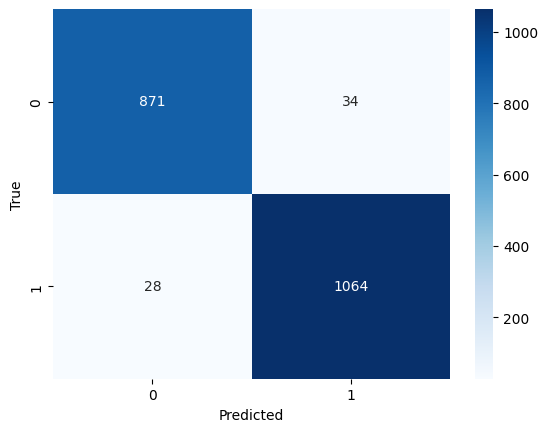

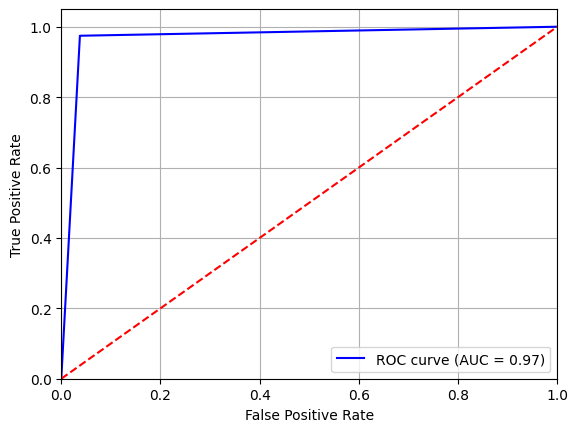

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

conf_matrix = evaluate.load("confusion_matrix")

pred_output = trainer.predict(tokenized_data["test"])
predictions = pred_output.predictions
labels = pred_output.label_ids

print("Metrics:", compute_metrics((predictions, labels)))

results = conf_matrix.compute(predictions=np.argmax(predictions, axis=1), references=labels)
cm = np.array(results["confusion_matrix"])

sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.savefig("confusion_matrix_test_tiny.svg")
plt.show()

fpr, tpr, thresholds = roc_curve(labels, np.argmax(predictions, axis=1))
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.grid()
plt.savefig("roc_auc_curve_test_tiny.svg")
plt.show()

In [9]:
idx = 0

text = tokenized_data["test"][idx]["text"]
print(text)

example = tokenized_data["test"].select([idx])
prediction = trainer.predict(example)

predicted_label = np.argmax(prediction.predictions, axis=1)[0]
true_label = tokenized_data["test"][idx]["label"]
label_map = {0: "REAL", 1: "GENERATED"}
print(f"Predicted: {label_map[predicted_label]} vs. True: {label_map[true_label]}")

Asycfilt.dll shows up on memory dump from compromised system. It has been identified as being part of the same attack chain as Figure 2.


d:\Zuza\MAGISTERKA\AI-Generated-CTI\venv\Lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


Predicted: GENERATED vs. True: GENERATED


### Predict on base model data

In [10]:
base_model_dataset = Dataset.from_pandas(pd.read_json('detection_dataset_base_model.jsonl', lines=True)).filter(lambda example: example["text"] not in dataset)

tokenized_base_model_data = base_model_dataset.map(preprocess_function, batched=True)
tokenized_base_model_data = tokenized_base_model_data.cast_column("label", label_feature)
print("Base Model Data:", Counter(tokenized_base_model_data["label"]))

Filter:   0%|          | 0/3162 [00:00<?, ? examples/s]

Map:   0%|          | 0/3162 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/3162 [00:00<?, ? examples/s]

Base Model Data: Counter({0: 1581, 1: 1581})


Metrics: {'accuracy': 0.7106261859582542, 'precision': 0.7772463105654956, 'recall': 0.7106261859582542, 'f1': 0.6921315920553919, 'f2': 0.6932603686635945, 'roc_auc': np.float64(0.8861156018996936)}


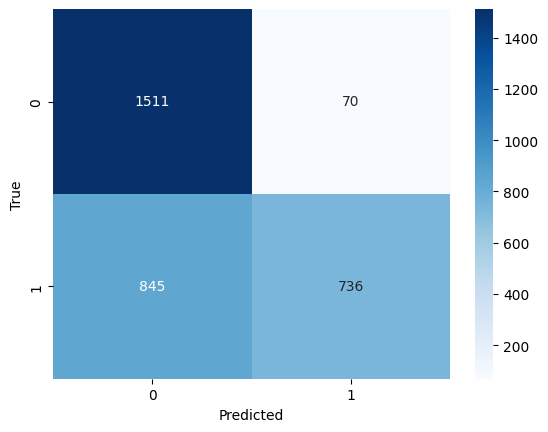

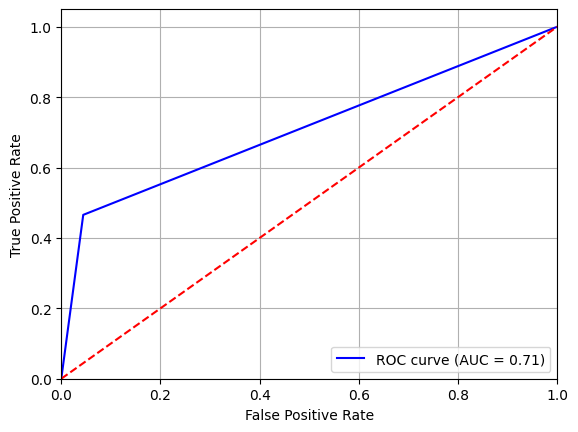

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

conf_matrix = evaluate.load("confusion_matrix")

pred_output = trainer.predict(tokenized_base_model_data)
predictions = pred_output.predictions
labels = pred_output.label_ids

print("Metrics:", compute_metrics((predictions, labels)))

results = conf_matrix.compute(predictions=np.argmax(predictions, axis=1), references=labels)
cm = np.array(results["confusion_matrix"])

sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
#plt.savefig("confusion_matrix_for_base_model.svg")
plt.show()

fpr, tpr, thresholds = roc_curve(labels, np.argmax(predictions, axis=1))
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.grid()
#plt.savefig("roc_auc_curve_for_base_model.svg")
plt.show()

### Predict on survey data

Metrics: {'accuracy': 0.9615384615384616, 'precision': 0.9643356643356642, 'recall': 0.9615384615384616, 'f1': 0.9615100031304249, 'f2': 0.9611857025650129, 'roc_auc': np.float64(0.9948205697373289)}


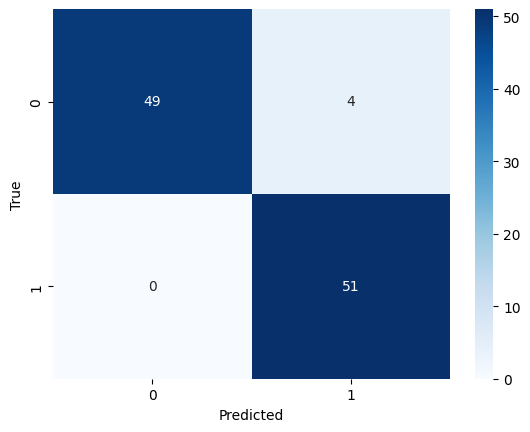

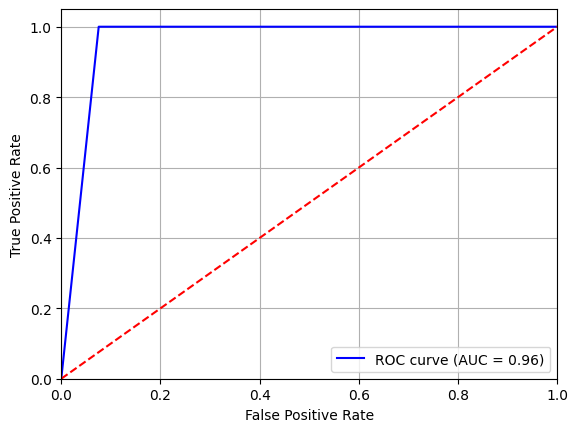

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

conf_matrix = evaluate.load("confusion_matrix")

pred_output = trainer.predict(tokenized_data_survey)
predictions = pred_output.predictions
labels = pred_output.label_ids

print("Metrics:", compute_metrics((predictions, labels)))

results = conf_matrix.compute(predictions=np.argmax(predictions, axis=1), references=labels)
cm = np.array(results["confusion_matrix"])

sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.savefig("confusion_matrix_for_survey_data_tiny.svg")
plt.show()

fpr, tpr, thresholds = roc_curve(labels, np.argmax(predictions, axis=1))
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.grid()
plt.savefig("roc_auc_curve_for_survey_data_tiny.svg")
plt.show()

### Predict on cleaned survey data

Filter:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/100 [00:00<?, ? examples/s]

Data: Counter({1: 50, 0: 50})


Metrics: {'accuracy': 0.82, 'precision': 0.8676470588235294, 'recall': 0.82, 'f1': 0.8139727159983464, 'f2': 0.8112454966546578, 'roc_auc': np.float64(0.9467999999999999)}


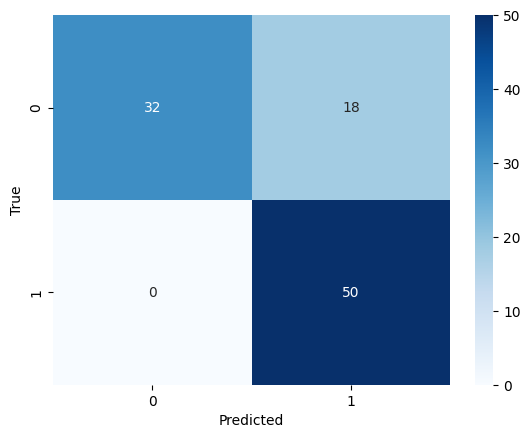

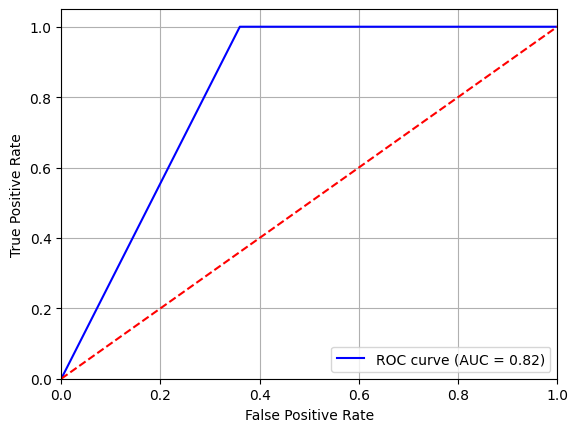

In [24]:
test_model_dataset = Dataset.from_pandas(pd.read_json('survey/samples_for_survey.jsonl', lines=True)).filter(lambda example: example["text"] not in dataset)

tokenized_test_data = test_model_dataset.map(preprocess_function, batched=True).cast_column("label", label_feature)
print("Data:", Counter(tokenized_test_data["label"]))

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

conf_matrix = evaluate.load("confusion_matrix")

pred_output = trainer.predict(tokenized_test_data)
predictions = pred_output.predictions
labels = pred_output.label_ids

print("Metrics:", compute_metrics((predictions, labels)))

results = conf_matrix.compute(predictions=np.argmax(predictions, axis=1), references=labels)
cm = np.array(results["confusion_matrix"])

sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.savefig("confusion_matrix_for_survey_data_cleaned_tiny.svg")
plt.show()

fpr, tpr, thresholds = roc_curve(labels, np.argmax(predictions, axis=1))
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.grid()
plt.savefig("roc_auc_curve_for_survey_data_cleaned_tiny.svg")
plt.show()

# Join two models into a single system

In [25]:
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_short = AutoModelForSequenceClassification.from_pretrained("bert-tiny-finetuned").to(device)
tokenizer_short = AutoTokenizer.from_pretrained("bert-tiny-finetuned")

model_long = AutoModelForSequenceClassification.from_pretrained("distilbert-finetuned").to(device)
tokenizer_long = AutoTokenizer.from_pretrained("distilbert-finetuned")

model_short.eval()
model_long.eval()

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): DistilBertSdpaAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)


100%|██████████| 1997/1997 [00:04<00:00, 420.23it/s]


Metrics: {'accuracy': 0.9824737105658488, 'precision': 0.9824941877164646, 'recall': 0.9824737105658488, 'f1': 0.9824777432806774, 'f2': 0.9824738331641218, 'roc_auc': np.float64(0.9980359419585939)}


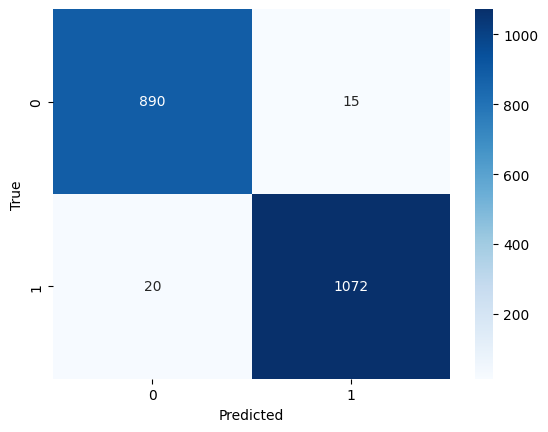

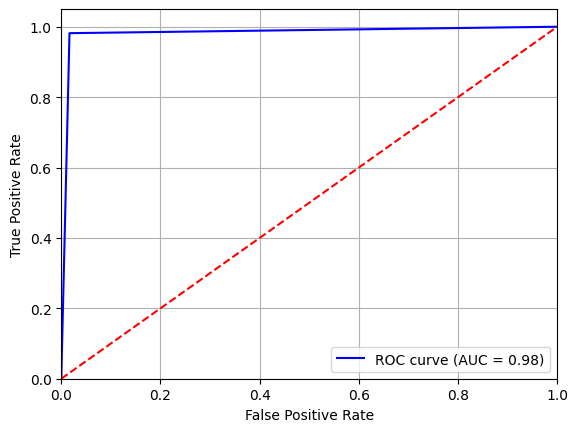

100%|██████████| 100/100 [00:00<00:00, 505.06it/s]

Metrics: {'accuracy': 0.82, 'precision': 0.8676470588235294, 'recall': 0.82, 'f1': 0.8139727159983464, 'f2': 0.8112454966546578, 'roc_auc': np.float64(0.95)}


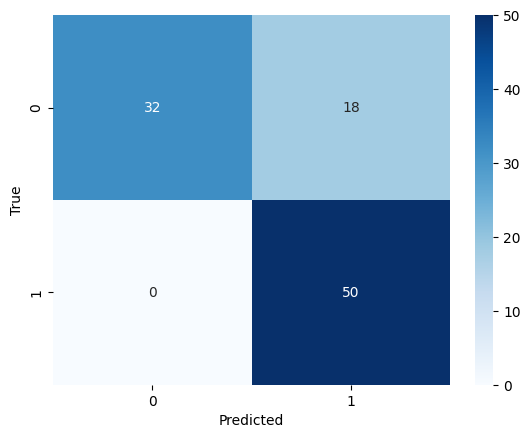

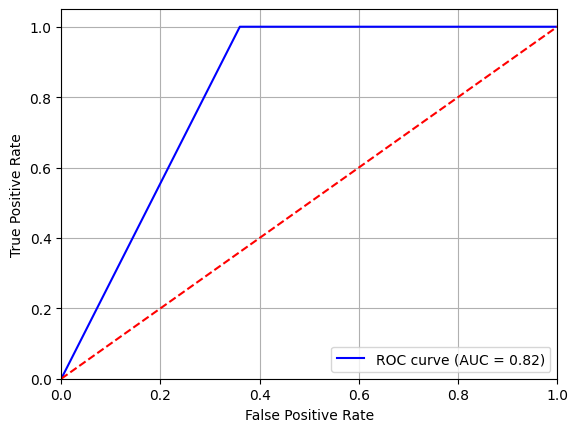

100%|██████████| 3162/3162 [00:06<00:00, 454.30it/s]


Metrics: {'accuracy': 0.870651486401012, 'precision': 0.8822155370438823, 'recall': 0.870651486401012, 'f1': 0.8696656598424266, 'f2': 0.8686772391826114, 'roc_auc': np.float64(0.9456508562903647)}


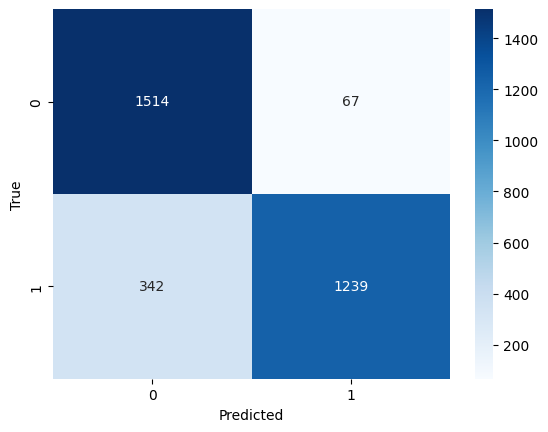

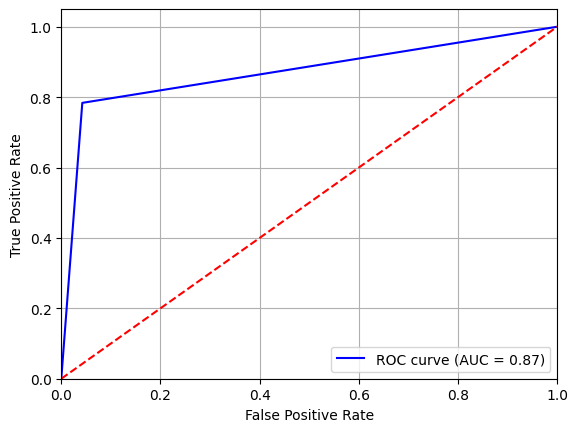

In [35]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from tqdm import tqdm

conf_matrix = evaluate.load("confusion_matrix")

def predict_with_hybrid_system(text, tokenizer_short, model_short, tokenizer_long, model_long, threshold=60):
    tokens = tokenizer_long(text, return_tensors="pt", truncation=True, padding=True)
    token_count = tokens['attention_mask'].sum().item()
    if token_count < threshold:
        inputs = tokenizer_short(text, return_tensors="pt", truncation=True, padding=True)
        chosen_model = model_short
    else:
        inputs = tokens
        chosen_model = model_long

    inputs = {k: v.to(device) for k, v in inputs.items()}
    with torch.no_grad():
        outputs = chosen_model(**inputs)
        logits = outputs.logits
        probs = torch.softmax(logits, dim=-1)
        pred_label = torch.argmax(probs, dim=-1).item()
    
    return pred_label, probs.cpu().numpy()


def evaluate_hybrid_system(tokenized_data_for_eval, tokenizer_short, model_short, tokenizer_long, model_long, name, threshold=60):
    pred_output = [
        predict_with_hybrid_system(text, tokenizer_short, model_short, tokenizer_long, model_long, threshold=threshold)
        for text in tqdm(tokenized_data_for_eval["text"])
    ]
    pred_labels, pred_probs = zip(*pred_output)
    labels = tokenized_data_for_eval["label"]

    print("Metrics:", compute_metrics((np.vstack([p for p in pred_probs]), labels)))

    results = conf_matrix.compute(predictions=pred_labels, references=labels)

    cm = np.array(results["confusion_matrix"])

    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.savefig(f"confusion_matrix_{name}.svg")
    plt.show()

    fpr, tpr, thresholds = roc_curve(labels, [np.argmax(p) for p in pred_probs])
    roc_auc = auc(fpr, tpr)

    plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='red', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc="lower right")
    plt.grid()
    plt.savefig(f"roc_auc_curve_{name}.svg")
    plt.show()

evaluate_hybrid_system(tokenized_data["test"], tokenizer_short, model_short, tokenizer_long, model_long, "test_data_combined", threshold=100)
evaluate_hybrid_system(test_model_dataset, tokenizer_short, model_short, tokenizer_long, model_long, "survey_data_combined", threshold=100)
evaluate_hybrid_system(base_model_dataset, tokenizer_short, model_short, tokenizer_long, model_long, "base_model_combined", threshold=100)